# Strawberry detection & segmentation - Mask RCNN

### Mask RCNN training

In [1]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Get the training parameters.
BATCH_SIZE  = 4
IMG_SIZE    = [1024, 1024]

In [4]:
# Get the dataset sources.
#DATASET_IMGS    = "../dataset/images"
#DATASET_SEGM    = "../dataset/instance_segmentation"

DATASET_IMGS    = "/content/drive/MyDrive/computer_vision_final_project/dataset/images"
DATASET_SEGM    = "/content/drive/MyDrive/computer_vision_final_project/dataset/instance_segmentation"

In [5]:
# Get the best available device.
if torch.cuda.is_available():
    device = torch.device('cuda')    # NVIDIA CUDA Acceleration.

else:
    device = torch.device('cpu')     # CPU.

In [6]:
# Get the dataset into variables.
all_base_images = []
all_segm_images = []

# Get all the images within the path.
for pth in os.listdir(DATASET_IMGS):

    all_base_images.append(DATASET_IMGS + "/" + pth)
    all_segm_images.append(DATASET_SEGM + "/" + pth)

In [7]:
from sklearn.model_selection import train_test_split

base_images, test_base, segm_images, test_segm = train_test_split(all_base_images, all_segm_images, test_size=0.1)

In [8]:
def load_data():
    
    batch_imgs = []
    batch_data = []

    for i in range(BATCH_SIZE):

        # Get the index for the image.
        idx = random.randint(0, len(base_images) - 1)

        # Load the image.
        img = cv2.imread(base_images[idx])
        img = cv2.resize(img, IMG_SIZE, cv2.INTER_LINEAR)

        # Load the mask.
        masks=[]
        all_masks = cv2.imread(segm_images[idx], 0)
        masks_labels = [l for l in np.unique(all_masks) if l != 0]

        # Iterate through the labels to get the masks.
        for label_id in masks_labels:

            # Get that label as an isolated mask.
            mask_i = (all_masks == label_id).astype(np.uint8)  # Read vesse instance mask

            # Resize it and append it as well.
            mask_i = cv2.resize(mask_i, IMG_SIZE, cv2.INTER_NEAREST)
            masks.append(mask_i) # Get bounding box coordinates for each mask.

        # Check if everything loaded correctly.
        num_objs = len(masks)
        if num_objs==0: return load_data() # if image have no objects just load another image

        # Get the boxes.
        boxes = torch.zeros([num_objs,4], dtype=torch.float32)
        for i in range(num_objs):
            x, y, w, h = cv2.boundingRect(masks[i])
            boxes[i] = torch.tensor([x, y, x+w, y+h])

        # Get the final objects for the training.
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        img = torch.as_tensor(img, dtype=torch.float32)

        # Build the feature dictionary that will be fed to PyTorch.
        data = {}
        data["boxes"]   = boxes
        data["labels"]  = torch.ones((num_objs,), dtype=torch.int64)   # there is only one class
        data["masks"]   = masks

        batch_imgs.append(img)
        batch_data.append(data)  # load images and masks

    batch_imgs = torch.stack([torch.as_tensor(d) for d in batch_imgs], 0)
    batch_imgs = batch_imgs.swapaxes(1, 3).swapaxes(2, 3)
    return batch_imgs, batch_data

In [9]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)  # load an instance segmentation model pre-trained pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=2)  # replace the pre-trained head with a new one
model.to(device) # move model to the right device

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
info = model.train()

In [10]:
MODEL_FN  = '/content/drive/MyDrive/computer_vision_final_project/Mask RCNN/mask_rcnn.torch'

In [11]:
# Check if the file exists to train it or not.
if not os.path.isfile(MODEL_FN):

  for i in range(4001):
    
    images, targets = load_data()
    images = list(image.to(device) for image in images)

    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    losses.backward()
    optimizer.step()

    print(i,'loss:', losses.item())
    
  torch.save(model.state_dict(), MODEL_FN)

0 loss: 205.99842834472656
1 loss: 134.6395721435547
2 loss: 82.95894622802734
3 loss: 62.47111129760742
4 loss: 47.48488235473633
5 loss: 50.204620361328125
6 loss: 65.84320068359375
7 loss: 35.999202728271484
8 loss: 46.48210525512695
9 loss: 31.967609405517578
10 loss: 34.05140686035156
11 loss: 16.176103591918945
12 loss: 27.231792449951172
13 loss: 61.394508361816406
14 loss: 31.631650924682617
15 loss: 23.13462257385254
16 loss: 20.25687026977539
17 loss: 27.555686950683594
18 loss: 19.23219108581543
19 loss: 11.208405494689941
20 loss: 14.744613647460938
21 loss: 21.040576934814453
22 loss: 14.886337280273438
23 loss: 12.147682189941406
24 loss: 11.4857759475708
25 loss: 7.093259811401367
26 loss: 8.24480152130127
27 loss: 9.49548053741455
28 loss: 27.211254119873047
29 loss: 8.547718048095703
30 loss: 13.726547241210938
31 loss: 7.018220901489258
32 loss: 11.58284854888916
33 loss: 14.972182273864746
34 loss: 10.949322700500488
35 loss: 11.340259552001953
36 loss: 6.79574918746

In [12]:
! cp "mask_rcnn.torch" "/content/drive/MyDrive/computer_vision_final_project/Mask RCNN/mask_rcnn.torch"

### Evaluation

In [13]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # load an instance segmentation model pre-trained pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)  # replace the pre-trained head with a new one
model.load_state_dict(torch.load(MODEL_FN))
model.to(device) # move model to the right devic
model.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [19]:
# Init the accuracy.
accuracy = 0
counting_each = []

for i in range(len(test_base)):

    print('Running', i)

    # Get the images.
    base_img = test_base[i]
    segm_img = test_segm[i]

    # Read the image.
    images = cv2.imread(base_img)
    images = cv2.resize(images, IMG_SIZE, cv2.INTER_LINEAR)
    images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
    images = images.swapaxes(1, 3).swapaxes(2, 3)
    images = list(image.to(device) for image in images)

    # Predict what we want.
    with torch.no_grad():
      pred = model(images)

    # Read the expected segmentation.
    segmentation_true = cv2.imread(segm_img, 0)
    segmentation_true = cv2.resize(segmentation_true, IMG_SIZE, cv2.INTER_LINEAR)
    segmentation_true[segmentation_true != 0] = 1

    # Get an empty image where we will put the masks.
    im = images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
    res_pred = np.zeros((im.shape[0], im.shape[1]))

    # Init the count of strawberries.
    count_strawberries = 0

    # Loop through the masks.
    for i in range(len(pred[0]['masks'])):

        msk = pred[0]['masks'][i,0].detach().cpu().numpy()
        scr = pred[0]['scores'][i].detach().cpu().numpy()
        msk = cv2.resize(msk, IMG_SIZE, cv2.INTER_LINEAR)
        
        if scr > 0.8:
            res_pred[msk > 0.5] = 1
            count_strawberries += 1

    # Normalize it.
    res_pred[res_pred != 0] = 1

    # Now we have the predicted mask and the true mask.
    # Let's get this accuracy.
    res_pred = np.array(res_pred)
    segmentation_true = np.array(segmentation_true)

    segmentation_union = res_pred + segmentation_true
    segmentation_union[segmentation_union != 0] = 1

    segmentation_inter = res_pred * segmentation_true
    
    img_accuracy = np.sum(segmentation_inter) / np.sum(segmentation_union)

    # Add it to the accuracy.
    accuracy += img_accuracy
    counting_each += [count_strawberries]

# Get the final accuracy.
print('The accuracy is', accuracy / len(test_base) * 100, '%')

Running 0
Running 1
Running 2
Running 3
Running 4
Running 5
Running 6
Running 7
Running 8
Running 9
Running 10
Running 11
Running 12
Running 13
Running 14
Running 15
Running 16
Running 17
Running 18
Running 19
Running 20
Running 21
Running 22
Running 23
Running 24
Running 25
Running 26
Running 27
Running 28
Running 29
Running 30
Running 31
Running 32
Running 33
Running 34
Running 35
Running 36
Running 37
Running 38
Running 39
Running 40
Running 41
Running 42
Running 43
Running 44
Running 45
Running 46
Running 47
Running 48
Running 49
Running 50
Running 51
Running 52
Running 53
Running 54
Running 55
Running 56
Running 57
Running 58
Running 59
Running 60
Running 61
Running 62
Running 63
Running 64
Running 65
Running 66
Running 67
Running 68
Running 69
Running 70
Running 71
Running 72
Running 73
Running 74
Running 75
Running 76
Running 77
Running 78
Running 79
Running 80
Running 81
Running 82
Running 83
Running 84
Running 85
Running 86
Running 87
Running 88
Running 89
Running 90
Running 9

### Testing

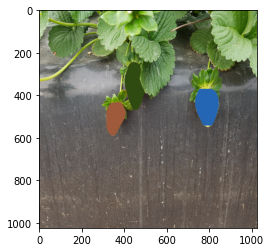

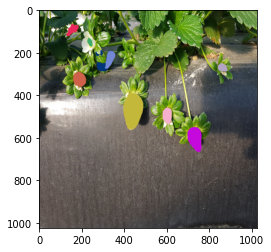

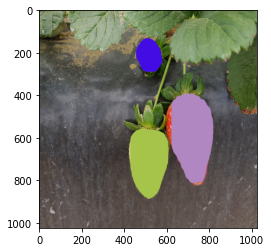

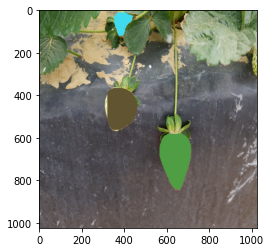

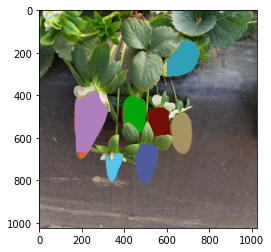

In [20]:
DATASET_TEST = '/content/drive/MyDrive/computer_vision_final_project/Mask RCNN/input/'

for pth in os.listdir(DATASET_TEST):

    # Get the image
    imgPath = DATASET_TEST + pth

    images = cv2.imread(imgPath)
    images = cv2.resize(images, IMG_SIZE, cv2.INTER_LINEAR)
    images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
    images = images.swapaxes(1, 3).swapaxes(2, 3)
    images = list(image.to(device) for image in images)

    # Predict it.
    with torch.no_grad():
        pred = model(images)

    # Get the image ready for overlay.
    im = images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
    im2 = im.copy()

    # Init the count of strawberries.
    count_strawberries = 0

    # Iterate through the masks.
    for i in range(len(pred[0]['masks'])):

        # Get the output.
        msk=pred[0]['masks'][i,0].detach().cpu().numpy()
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        msk = cv2.resize(msk, IMG_SIZE, cv2.INTER_LINEAR)

        # If it is trustworthy.
        if scr > 0.8:

            im2[:,:,0][msk>0.5] = random.randint(0,255)
            im2[:, :, 1][msk > 0.5] = random.randint(0,255)
            im2[:, :, 2][msk > 0.5] = random.randint(0, 255)

            count_strawberries += 1

    plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
    plt.show()

    print('There are', count_strawberries, 'strawberries.')